<a href="https://colab.research.google.com/github/yourusername/qdrant-resources/blob/main/01_qdrant_101/qdrant_101_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qdrant 101: Getting Started with Vector Search

Welcome to the complete beginner's guide to Qdrant! In this tutorial, you'll learn:

- ✅ What is Qdrant and why use it?
- ✅ Creating your first vector collection
- ✅ Adding documents and vectors
- ✅ Performing semantic search
- ✅ Filtering results with metadata
- ✅ Best practices and optimization tips

**Duration:** ~30 minutes (maybe less) <br>
**Level:** Beginner  
**Requirements:** Basic Python knowledge

## Setup and Installation

In [ ]:
!pip install -q qdrant-client[fastembed] sentence-transformers pandas numpy tqdm matplotlib -q 

import warnings
warnings.filterwarnings('ignore')

print("Dependencies installed successfully!")

## What is Qdrant?

Qdrant is a **vector similarity search engine** that allows you to:

- **Search by meaning** instead of exact keywords
- **Scale to billions** of vectors efficiently  
- **Filter by metadata** for precise results
- **Real-time updates** and millisecond search
- **Easy integration** with AI/ML pipelines

### Key Concepts:
- **Vector**: Numerical representation of data (text, images, audio)
- **Collection**: Container for vectors with same configuration
- **Point**: Vector + metadata + unique ID
- **Similarity Search**: Find vectors closest to a query vector

> **Want to learn more?** Check out this comprehensive article: [Vector Search: How Qdrant Makes Finding Needles in Haystacks Actually Fun](https://medium.com/@mohammedarbinsibi/vector-search-how-qdrant-makes-finding-needles-in-haystacks-actually-fun-96413694b2a8)

## Initialize Qdrant Client

In [ ]:
from qdrant_client import QdrantClient, models
from qdrant_client.models import (
    Distance,
    VectorParams,
    PointStruct,
    Filter,
    FieldCondition,
    MatchValue
)
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import uuid

#initialize Qdrant in memory mode (perfect for tutorials)
print(f"Running in RAM mode for this tutorial")
client = QdrantClient(":memory:")  # Uses RAM instead of disk

# print(f"Running in disk mode for this tutorial")
# client = QdrantClient(path = "qdrant_db")  # Uses disk instead of RAM
print("Qdrant client initialized successfully!")

Running in RAM mode for this tutorial
Qdrant client initialized successfully!


## Sample Data: Tech Articles

Let's create a dataset of technology articles to demonstrate vector search capabilities.

In [27]:
# Sample technology articles dataset
tech_articles = [
    {
        "id": 1,
        "title": "Introduction to Machine Learning",
        "content": "Machine learning is a subset of artificial intelligence that enables computers to learn and make decisions from data without being explicitly programmed.",
        "category": "AI",
        "author": "Mohamed Arbi",
        "year": 2024,
        "difficulty": "beginner"
    },
    {
        "id": 2,
        "title": "Vector Databases Explained",
        "content": "Vector databases store high-dimensional vectors and enable similarity search for AI applications, RAG systems, and recommendation engines.",
        "category": "Database",
        "author": "Lionel Messi",
        "year": 2024,
        "difficulty": "intermediate"
    },
    {
        "id": 3,
        "title": "Deep Learning with Neural Networks",
        "content": "Deep learning uses multi-layer neural networks to model and understand complex patterns in large amounts of data.",
        "category": "AI",
        "author": "Zlatan Ibrahimović",
        "year": 2024,
        "difficulty": "advanced"
    },
    {
        "id": 4,
        "title": "Building Scalable Web APIs",
        "content": "Learn best practices for designing REST APIs that can handle millions of requests per day using proper caching and database optimization.",
        "category": "Web Development",
        "author": "Lionel Messi",
        "year": 2024,
        "difficulty": "intermediate"
    },
    {
        "id": 5,
        "title": "Quantum Computing Basics",
        "content": "Quantum computing leverages quantum mechanical phenomena like superposition and entanglement to process information in revolutionary ways.",
        "category": "Quantum",
        "author": "Dr.Diego Maradona",
        "year": 2024,
        "difficulty": "advanced"
    },
    {
        "id": 6,
        "title": "Cloud Storage Solutions",
        "content": "Compare different cloud storage providers and learn about data durability, availability, and cost optimization strategies.",
        "category": "Cloud",
        "author": "Ronaldinho",
        "year": 2024,
        "difficulty": "beginner"
    },
    {
        "id": 7,
        "title": "Natural Language Processing Fundamentals",
        "content": "NLP combines linguistics and machine learning to help computers understand, interpret, and generate human language.",
        "category": "AI",
        "author": "Erling Haaland",
        "year": 2024,
        "difficulty": "intermediate"
    },
    {
        "id": 8,
        "title": "Blockchain Technology Overview",
        "content": "Blockchain is a distributed ledger technology that maintains a continuously growing list of records secured using cryptography.",
        "category": "Blockchain",
        "author": "Erling Haaland",
        "year": 2024,
        "difficulty": "intermediate"
    }
]

# Convert to DataFrame
df = pd.DataFrame(tech_articles)
print(f"Created dataset with {len(tech_articles)} articles")
print("\n Sample articles:")
display(df[["title", "category", "difficulty"]].head())

Created dataset with 8 articles

 Sample articles:


,title,category,difficulty
0,Introduction to Machine Learning,AI,beginner
1,Vector Databases Explained,Database,intermediate
2,Deep Learning with Neural Networks,AI,advanced
3,Building Scalable Web APIs,Web Development,intermediate
4,Quantum Computing Basics,Quantum,advanced


## Step 1: Create Vector Embeddings

We need to convert text into vectors using an embedding model. We'll use Sentence Transformers for this.

In [28]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained embedding model
print("Loading embedding model...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # 384-dimensional embeddings
print(f"Model loaded! Vector dimension: {model.get_sentence_embedding_dimension()}")

# Create embeddings
print("\n Creating embeddings for articles...")
texts = [f"{article['title']}. {article['content']}" for article in tech_articles]
embeddings = model.encode(texts, show_progress_bar=True)

print(f"\n Created {len(embeddings)} embeddings of dimension {embeddings.shape[1]}")

Loading embedding model...
Model loaded! Vector dimension: 384

 Creating embeddings for articles...
Model loaded! Vector dimension: 384

 Creating embeddings for articles...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 Created 8 embeddings of dimension 384


## Step 2: Create a Qdrant Collection

A collection is like a table in a database - it stores vectors with the same configuration.

In [30]:
collection_name = "tech_articles"

client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embeddings.shape[1],  # Vector dimension (384)
        distance=Distance.COSINE 
    )
)

print(f"Collection '{collection_name}' created successfully!")
print(f"Vector dimension: {embeddings.shape[1]}")

Collection 'tech_articles' created successfully!
Vector dimension: 384


## Step 3: Upload Data to Collection

Now let's add our articles as "points" (vector + metadata + ID) to the collection.

In [31]:
points = []

for i, (article, embedding) in enumerate(zip(tech_articles, embeddings)):
    point = PointStruct(
        id=article["id"],  # identifier
        vector=embedding.tolist(),  # Convert numpy array to list
        payload={
            "title": article["title"],
            "content": article["content"],
            "category": article["category"],
            "author": article["author"],
            "year": article["year"],
            "difficulty": article["difficulty"]
        }
    )
    points.append(point)

print("Uploading points to collection...")
operation_info = client.upsert(
    collection_name=collection_name,
    points=points
)

print(f"Successfully uploaded {len(points)} points!")
print(f"Operation status: {operation_info.status}")

# Verify collection info
collection_info = client.get_collection(collection_name)
print(f"\n Collection status:")
print(f"  - Points: {collection_info.points_count}")
print(f"  - Vectors: {collection_info.vectors_count}")
print(f"  - Status: {collection_info.status}")

Uploading points to collection...
Successfully uploaded 8 points!
Operation status: completed

 Collection status:
  - Points: 8
  - Vectors: None
  - Status: green


## Step 4: Perform Semantic Search

Now comes the magic! Let's search for articles using natural language queries.

In [32]:
def search_articles(query, limit=3):
    """Search for articles using semantic similarity"""
    
    query_vector = model.encode(query).tolist()
    
    search_results = client.search(
        collection_name=collection_name,
        query_vector=query_vector,
        limit=limit,
        with_payload=True  # Include metadata in results
    )
    
    print(f"Query: '{query}'")
    print(f"Found {len(search_results)} results\n")
    
    for i, result in enumerate(search_results, 1):
        print(f"Result {i} (Score: {result.score:.3f})")
        print(f" Title: {result.payload['title']}")
        print(f" Category: {result.payload['category']}")
        print(f" Content: {result.payload['content'][:100]}...")
        print()
    
    return search_results

print("Testing semantic search capabilities:\n")
results1 = search_articles("artificial intelligence and learning algorithms")


Testing semantic search capabilities:

Query: 'artificial intelligence and learning algorithms'
Found 3 results

Result 1 (Score: 0.602)
 Title: Introduction to Machine Learning
 Category: AI
 Content: Machine learning is a subset of artificial intelligence that enables computers to learn and make dec...

Result 2 (Score: 0.405)
 Title: Deep Learning with Neural Networks
 Category: AI
 Content: Deep learning uses multi-layer neural networks to model and understand complex patterns in large amo...

Result 3 (Score: 0.388)
 Title: Vector Databases Explained
 Category: Database
 Content: Vector databases store high-dimensional vectors and enable similarity search for AI applications, RA...



C:\Users\MSI\AppData\Local\Temp\ipykernel_23784\183034910.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


In [33]:
print("\n" + "="*50 + "\n")
results2 = search_articles("storing and managing data efficiently")



Query: 'storing and managing data efficiently'
Found 3 results

Result 1 (Score: 0.348)
 Title: Cloud Storage Solutions
 Category: Cloud
 Content: Compare different cloud storage providers and learn about data durability, availability, and cost op...

Result 2 (Score: 0.342)
 Title: Building Scalable Web APIs
 Category: Web Development
 Content: Learn best practices for designing REST APIs that can handle millions of requests per day using prop...

Result 3 (Score: 0.214)
 Title: Deep Learning with Neural Networks
 Category: AI
 Content: Deep learning uses multi-layer neural networks to model and understand complex patterns in large amo...



C:\Users\MSI\AppData\Local\Temp\ipykernel_23784\183034910.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


In [34]:
print("\n" + "="*50 + "\n")
results3 = search_articles("future computing technologies")



Query: 'future computing technologies'
Found 3 results

Result 1 (Score: 0.398)
 Title: Quantum Computing Basics
 Category: Quantum
 Content: Quantum computing leverages quantum mechanical phenomena like superposition and entanglement to proc...

Result 2 (Score: 0.293)
 Title: Blockchain Technology Overview
 Category: Blockchain
 Content: Blockchain is a distributed ledger technology that maintains a continuously growing list of records ...

Result 3 (Score: 0.284)
 Title: Cloud Storage Solutions
 Category: Cloud
 Content: Compare different cloud storage providers and learn about data durability, availability, and cost op...



C:\Users\MSI\AppData\Local\Temp\ipykernel_23784\183034910.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


## Step 5: Filtering with Metadata

One of Qdrant's most powerful features is the ability to combine semantic search with traditional filtering.

In [35]:
def search_with_filter(query, filter_conditions, limit=3):
    """Search with metadata filtering"""
    
    query_vector = model.encode(query).tolist()
    
    # Search with filters
    search_results = client.search(
        collection_name=collection_name,
        query_vector=query_vector,
        query_filter=filter_conditions, # will be defined as needed later 
        limit=limit,
        with_payload=True
    )
    
    return search_results

# Example: Find AI articles for beginners
print("Example: AI articles for beginners\n")

ai_beginner_filter = Filter(
    must=[
        FieldCondition(
            key="category",
            match=MatchValue(value="AI")
        ),
        FieldCondition(
            key="difficulty",
            match=MatchValue(value="beginner")
        )
    ]
)

results = search_with_filter(
    query="machine learning introduction",
    filter_conditions=ai_beginner_filter
)

for i, result in enumerate(results, 1):
    print(f"Result {i} (Score: {result.score:.3f})")
    print(f" Title: {result.payload['title']}")
    print(f" Category: {result.payload['category']} | Difficulty: {result.payload['difficulty']}")
    print()

Example: AI articles for beginners

Result 1 (Score: 0.713)
 Title: Introduction to Machine Learning
 Category: AI | Difficulty: beginner



C:\Users\MSI\AppData\Local\Temp\ipykernel_23784\2769045028.py:7: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


In [36]:
# Example 2: Intermediate level articles (any category)
print("\n Example 2: Intermediate level articles\n")

intermediate_filter = Filter(
    must=[
        FieldCondition(
            key="difficulty",
            match=MatchValue(value="intermediate")
        )
    ]
)

results = search_with_filter(
    query="programming and development",
    filter_conditions=intermediate_filter,
    limit=5
)

for i, result in enumerate(results, 1):
    print(f"Result {i} (Score: {result.score:.3f})")
    print(f" Title: {result.payload['title']}")
    print(f" Category: {result.payload['category']} | Author: {result.payload['author']}")
    print()


 Example 2: Intermediate level articles

Result 1 (Score: 0.187)
 Title: Natural Language Processing Fundamentals
 Category: AI | Author: Erling Haaland

Result 2 (Score: 0.182)
 Title: Building Scalable Web APIs
 Category: Web Development | Author: Lionel Messi

Result 3 (Score: 0.130)
 Title: Vector Databases Explained
 Category: Database | Author: Lionel Messi

Result 4 (Score: 0.112)
 Title: Blockchain Technology Overview
 Category: Blockchain | Author: Erling Haaland



C:\Users\MSI\AppData\Local\Temp\ipykernel_23784\2769045028.py:7: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


## Step 6: Adding New Documents

Qdrant supports real-time updates. Let's add a new article to our collection.

In [37]:
# Add a new article about qdrant
new_article = {
    "id": 9,
    "title": "Qdrant Vector Search Tutorial",
    "content": "Learn how to build powerful semantic search applications using Qdrant vector database with real-time updates and filtering capabilities.",
    "category": "Database",
    "author": "Mohamed Arbi",
    "year": 2025,
    "difficulty": "beginner"
}

#embedding for new article
new_text = f"{new_article['title']}. {new_article['content']}"
new_embedding = model.encode(new_text).tolist()

# Add to collection
new_point = PointStruct(
    id=new_article["id"],
    vector=new_embedding,
    payload={
        "title": new_article["title"],
        "content": new_article["content"],
        "category": new_article["category"],
        "author": new_article["author"],
        "year": new_article["year"],
        "difficulty": new_article["difficulty"]
    }
)

#upload the new point
client.upsert(
    collection_name=collection_name,
    points=[new_point]
)

print("Added new article to collection!")

updated_collection = client.get_collection(collection_name)
print(f"Collection now has {updated_collection.points_count} articles")

#test 
print("\nTesting search with new article:")
results = search_articles("vector database tutorial", limit=2)

Added new article to collection!
Collection now has 9 articles

Testing search with new article:
Query: 'vector database tutorial'
Found 2 results

Result 1 (Score: 0.643)
 Title: Vector Databases Explained
 Category: Database
 Content: Vector databases store high-dimensional vectors and enable similarity search for AI applications, RA...

Result 2 (Score: 0.494)
 Title: Qdrant Vector Search Tutorial
 Category: Database
 Content: Learn how to build powerful semantic search applications using Qdrant vector database with real-time...



C:\Users\MSI\AppData\Local\Temp\ipykernel_23784\183034910.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


## Step 7: Collection Analytics

Let's explore some analytics about our collection.

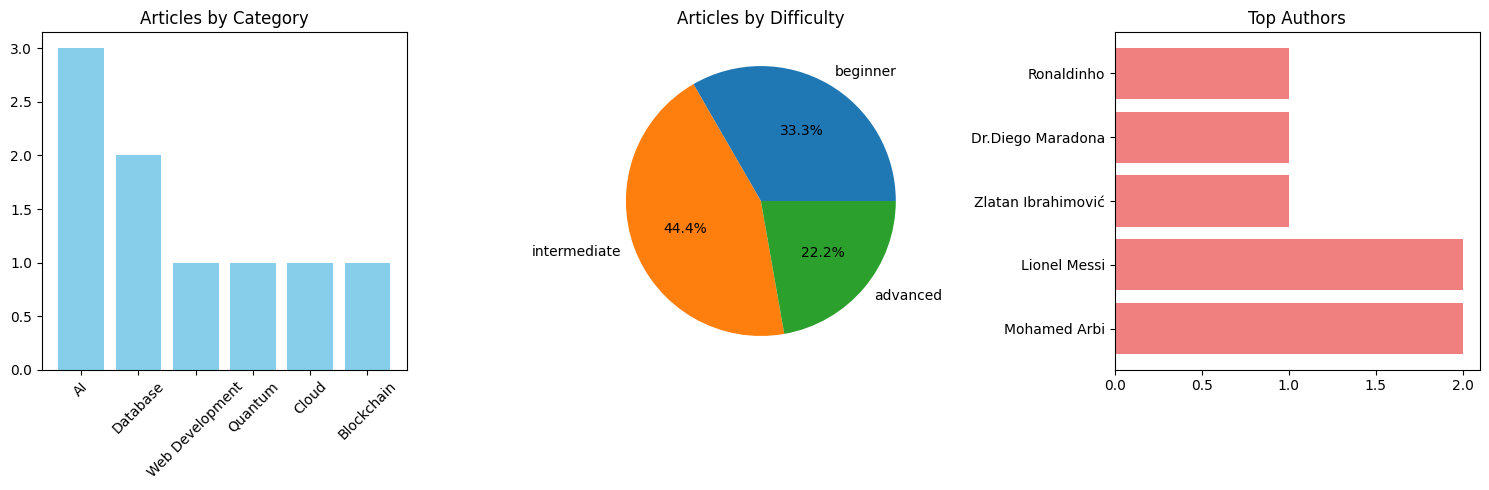

Collection Summary:
   Total articles: 9
   Categories: 6
   Authors: 6
   Difficulties: ['beginner', 'intermediate', 'advanced']


In [38]:
import matplotlib.pyplot as plt
from collections import Counter

#all points
all_points = client.scroll(
    collection_name=collection_name,
    with_payload=True,
    limit=100
)[0]

categories = [point.payload['category'] for point in all_points]
difficulties = [point.payload['difficulty'] for point in all_points]
authors = [point.payload['author'] for point in all_points]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# distribution
category_counts = Counter(categories)
axes[0].bar(category_counts.keys(), category_counts.values(), color='skyblue')
axes[0].set_title('Articles by Category')
axes[0].tick_params(axis='x', rotation=45)

# Difficulty distribution
difficulty_counts = Counter(difficulties)
axes[1].pie(difficulty_counts.values(), labels=difficulty_counts.keys(), autopct='%1.1f%%')
axes[1].set_title('Articles by Difficulty')

# Author distribution
author_counts = Counter(authors)
axes[2].barh(list(author_counts.keys())[:5], list(author_counts.values())[:5], color='lightcoral')
axes[2].set_title('Top Authors')

plt.tight_layout()
plt.show()

print("Collection Summary:")
print(f"   Total articles: {len(all_points)}")
print(f"   Categories: {len(category_counts)}")
print(f"   Authors: {len(author_counts)}")
print(f"   Difficulties: {list(difficulty_counts.keys())}")

## Step 8: Advanced Features Demo

Let's explore some advanced Qdrant features.

In [39]:
# 1. Recommendation System: Find articles similar to a given article
def recommend_similar_articles(article_id, limit=3):
    """Recommend articles similar to a given article"""
    
    article = client.retrieve(
        collection_name=collection_name,
        ids=[article_id],
        with_vectors=True,
        with_payload=True
    )[0]
    
    print(f"Finding articles similar to: '{article.payload['title']}'\n")
    
    # search excluding original
    similar_articles = client.search(
        collection_name=collection_name,
        query_vector=article.vector,
        limit=limit + 1,  # +1 because result will include the original
        with_payload=True
    )
    
    #filter out original article
    recommendations = [art for art in similar_articles if art.id != article_id]
    
    for i, rec in enumerate(recommendations[:limit], 1):
        print(f"Recommendation {i} (Similarity: {rec.score:.3f})")
        print(f"   Title: {rec.payload['title']}")
        print(f"   Category: {rec.payload['category']}")
        print()
    
    return recommendations

recommendations = recommend_similar_articles(article_id=1, limit=3)

Finding articles similar to: 'Introduction to Machine Learning'

Recommendation 1 (Similarity: 0.492)
   Title: Deep Learning with Neural Networks
   Category: AI

Recommendation 2 (Similarity: 0.405)
   Title: Natural Language Processing Fundamentals
   Category: AI

Recommendation 3 (Similarity: 0.395)
   Title: Vector Databases Explained
   Category: Database



C:\Users\MSI\AppData\Local\Temp\ipykernel_23784\1586522280.py:15: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  similar_articles = client.search(


In [40]:
# 2. Batch search: Search multiple queries at once
def batch_search(queries, limit=2):
    """Search multiple queries efficiently"""
    
    query_vectors = model.encode(queries).tolist()
    
    results = []
    for i, (query, vector) in enumerate(zip(queries, query_vectors)):
        search_result = client.search(
            collection_name=collection_name,
            query_vector=vector,
            limit=limit,
            with_payload=True
        )
        results.append((query, search_result))
    
    return results

print("\nBatch Search Example:\n")

queries = [
    "neural networks deep learning",
    "cloud storage solutions",
    "blockchain cryptocurrency"
]

batch_results = batch_search(queries)

for query, results in batch_results:
    print(f"Query: '{query}'")
    for result in results:
        print(f"   • {result.payload['title']} (Score: {result.score:.3f})")
    print()


Batch Search Example:

Query: 'neural networks deep learning'
   • Deep Learning with Neural Networks (Score: 0.617)
   • Introduction to Machine Learning (Score: 0.382)

Query: 'cloud storage solutions'
   • Cloud Storage Solutions (Score: 0.789)
   • Building Scalable Web APIs (Score: 0.287)

Query: 'blockchain cryptocurrency'
   • Blockchain Technology Overview (Score: 0.593)
   • Deep Learning with Neural Networks (Score: 0.145)



C:\Users\MSI\AppData\Local\Temp\ipykernel_23784\3788729280.py:9: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


## Performance Insights & Best Practices

Let's measure search performance and learn optimization tips.

In [41]:
import time

#search performance
def benchmark_search(num_queries=10):
    """Benchmark search performance"""
    
    test_queries = [
        "machine learning algorithms",
        "database optimization", 
        "web development frameworks",
        "artificial intelligence applications",
        "cloud computing services"
    ] * (num_queries // 5 + 1)
    
    test_queries = test_queries[:num_queries]
    
    start_time = time.time()
    
    for query in test_queries:
        query_vector = model.encode(query).tolist()
        client.search(
            collection_name=collection_name,
            query_vector=query_vector,
            limit=5
        )
    
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"Performance Benchmark Results:")
    print(f"   Total queries: {num_queries}")
    print(f"   Total time: {total_time:.3f} seconds")
    print(f"   Average per query: {(total_time/num_queries)*1000:.1f} ms")
    print(f"   Queries per second: {num_queries/total_time:.1f}")

benchmark_search(20)

Performance Benchmark Results:
   Total queries: 20
   Total time: 0.171 seconds
   Average per query: 8.6 ms
   Queries per second: 116.8


C:\Users\MSI\AppData\Local\Temp\ipykernel_23784\3209155800.py:21: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  client.search(


## Cleanup and Next Steps

In [ ]:
# Optional: Delete collection
client.delete_collection(collection_name)
print(f"Collection '{collection_name}' deleted")

## Tutorial Completed!

### What You Learned:
- Vector embeddings and similarity search
- Creating and managing Qdrant collections
- Uploading and searching vectors
- Metadata filtering and recommendations
- Performance optimization tips

### Next Steps:
- Try the Vector Quantization tutorial
- Explore Agents with Qdrant
- Build RAG systems with LlamaIndex
- Learn multimodal search with images
- Scale to production with optimization techniques

### Pro Tips:
- Experiment with different embedding models
- Try various distance metrics (cosine, dot, euclidean)
- Create payload indexes for faster filtering
- Use Qdrant Cloud for managed hosting


### Need Help?
- **Documentation:** https://qdrant.tech/documentation/
- **Discord:** https://discord.gg/qdrant
- **GitHub:** https://github.com/qdrant/qdrant

---
**Author:** [Mohamed Arbi Nsibi](https://www.linkedin.com/in/mohammed-arbi-nsibi-584a43241/)